In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день: Будет дождь, если rainfall >=1

In [2]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
df.shape

(145460, 23)

In [7]:
#удаление столбцов
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

In [6]:
#Удаление строк с пропущенными значениями
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


In [8]:
#Преобразование данный столбцов
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

<ipython-input-8-5fafd96e4ede>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
<ipython-input-8-5fafd96e4ede>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
<ipython-input-8-5

In [9]:
df[df['RainTomorrow']==0.0].count()

,0
Rainfall,97103
Humidity3pm,97103
Pressure9am,97103
RainToday,97103
RainTomorrow,97103


In [10]:
df[df['RainTomorrow']==1.0].count()

,0
Rainfall,27586
Humidity3pm,27586
Pressure9am,27586
RainToday,27586
RainTomorrow,27586


Классы находятся в несбалансированном состоянии

In [11]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Проводим преобразование в тензор

In [12]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


2)NET

In [14]:
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)

    # torch.nn.init.xavier_uniform_(self.fc1.weight)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [15]:
criterion = nn.BCELoss()

In [16]:
device = torch.device( "cpu")

In [17]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [18]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)

    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628505706787, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.5720739960670471, accuracy: 0.7959740161895752
    
epoch 200
    Test  set - loss: 0.5436038970947266, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333548188209534, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.5154792666435242, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.48074424266815186, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.46781307458877563, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.4557693302631378, accuracy: 0.784866452217102
    
epoch 800
    Test  set - loss: 0.44445592164993286, accuracy: 0.7911219596862793
    
epoch 900
    Test  set - loss: 0.4336666762828827, accuracy: 0.7984601855278015
    
epoch 1000
    Test  set - loss: 0.4242238998413086, accuracy: 0.8103296160697937
    
epoch 1100
    Test  set - loss: 0.4171040952205658, a

In [19]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [20]:
net = torch.load(MODEL_PATH)

<ipython-input-20-58455d427580>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(MODEL_PATH)


In [21]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.83      0.84      0.82     24938



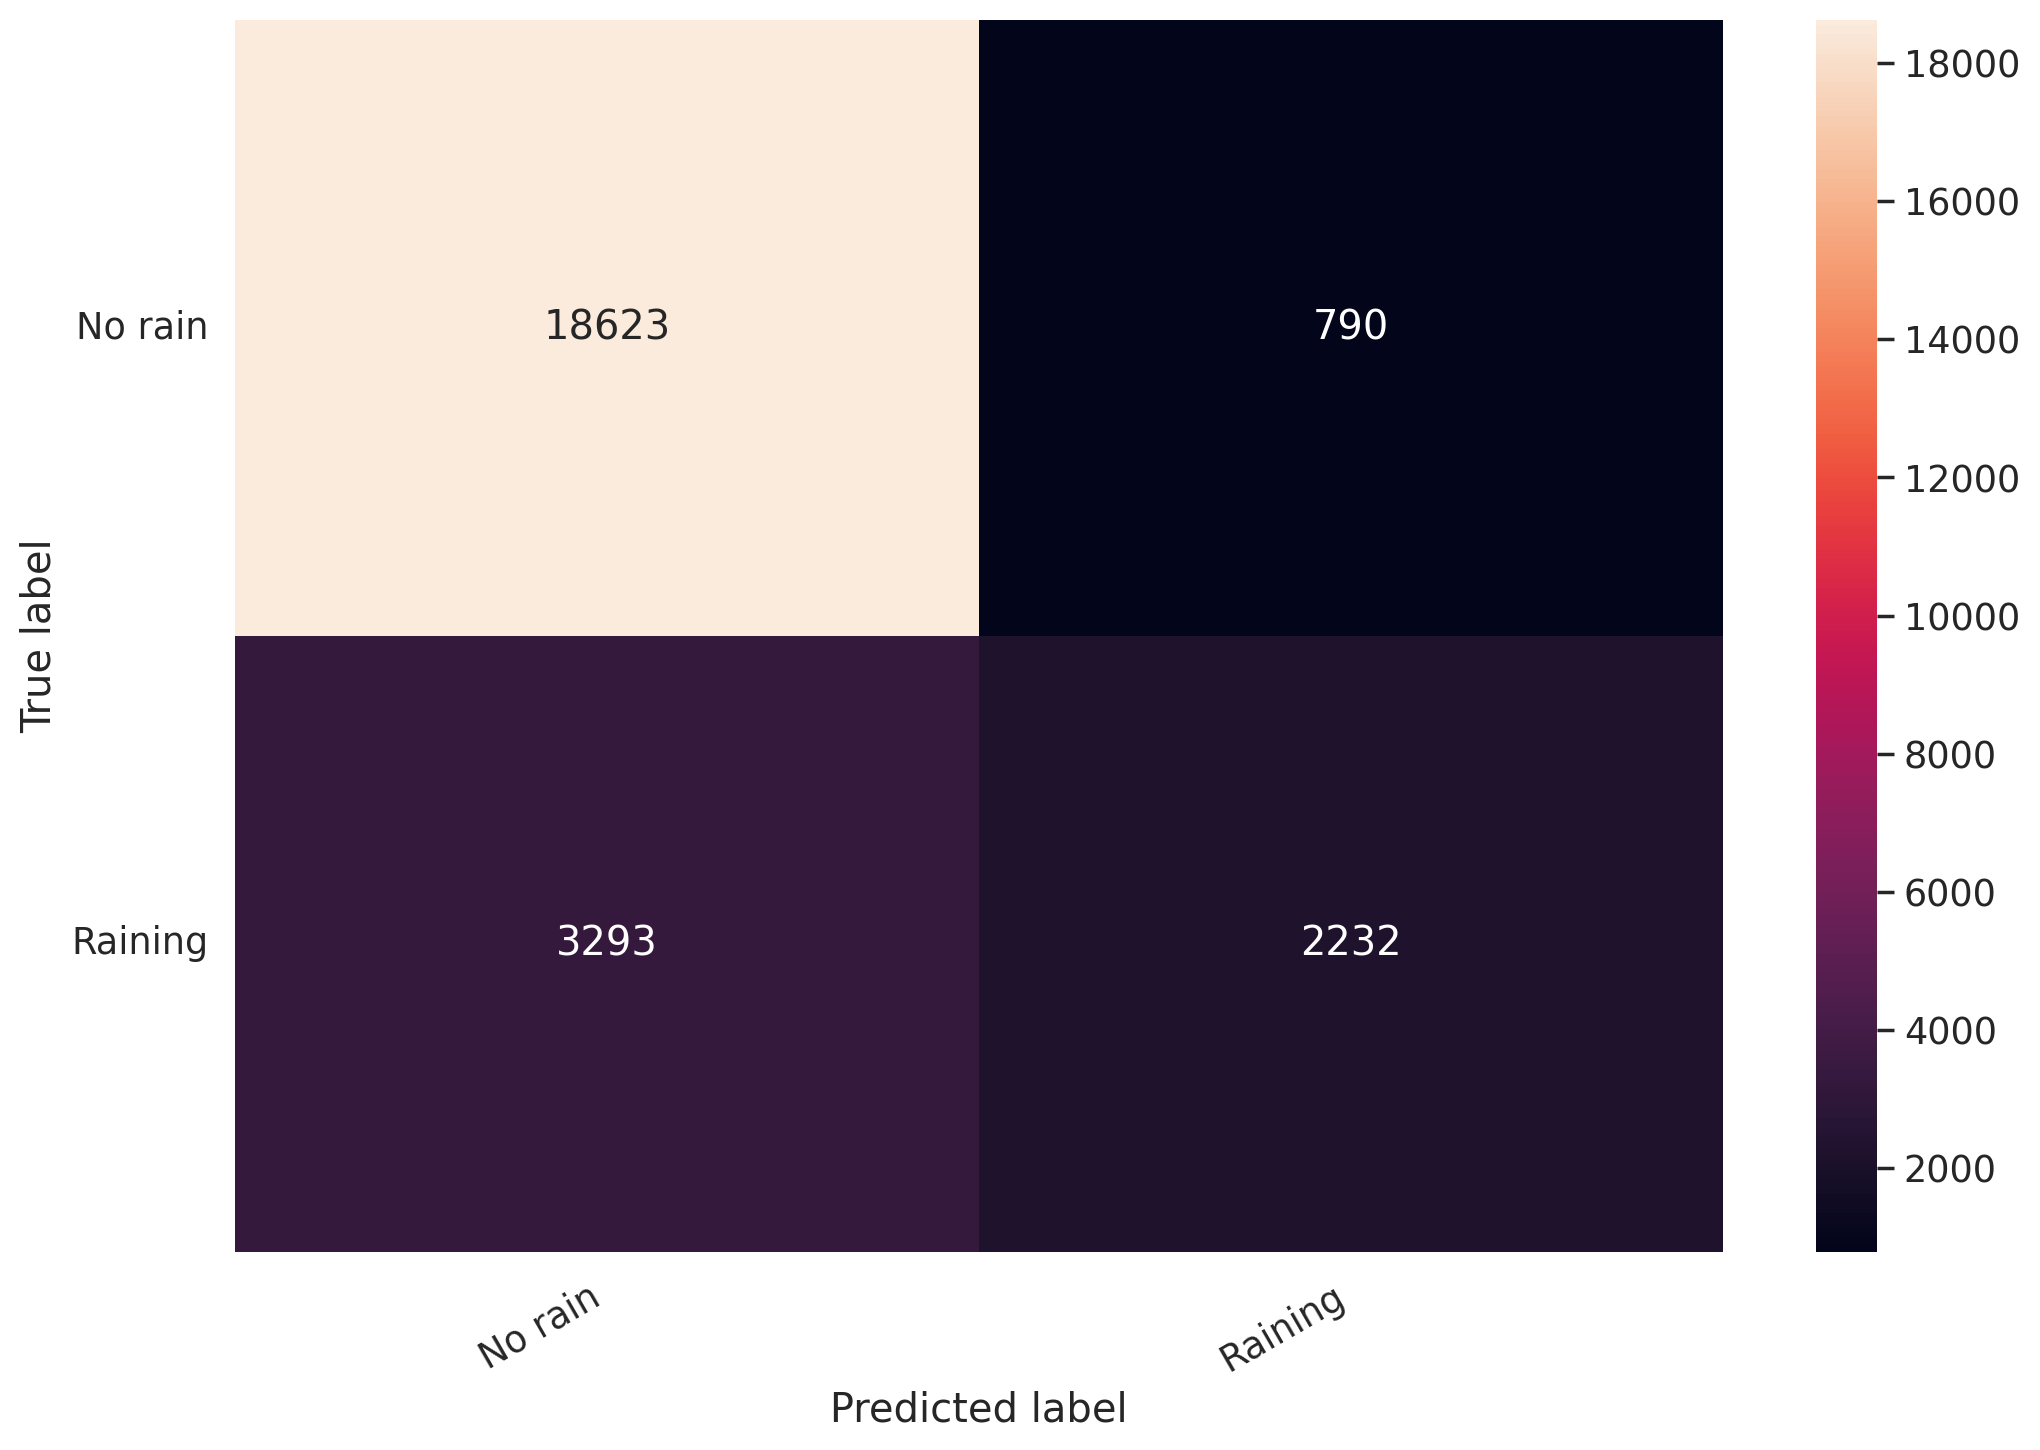

In [22]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate,
# выберите оптимальное значение.

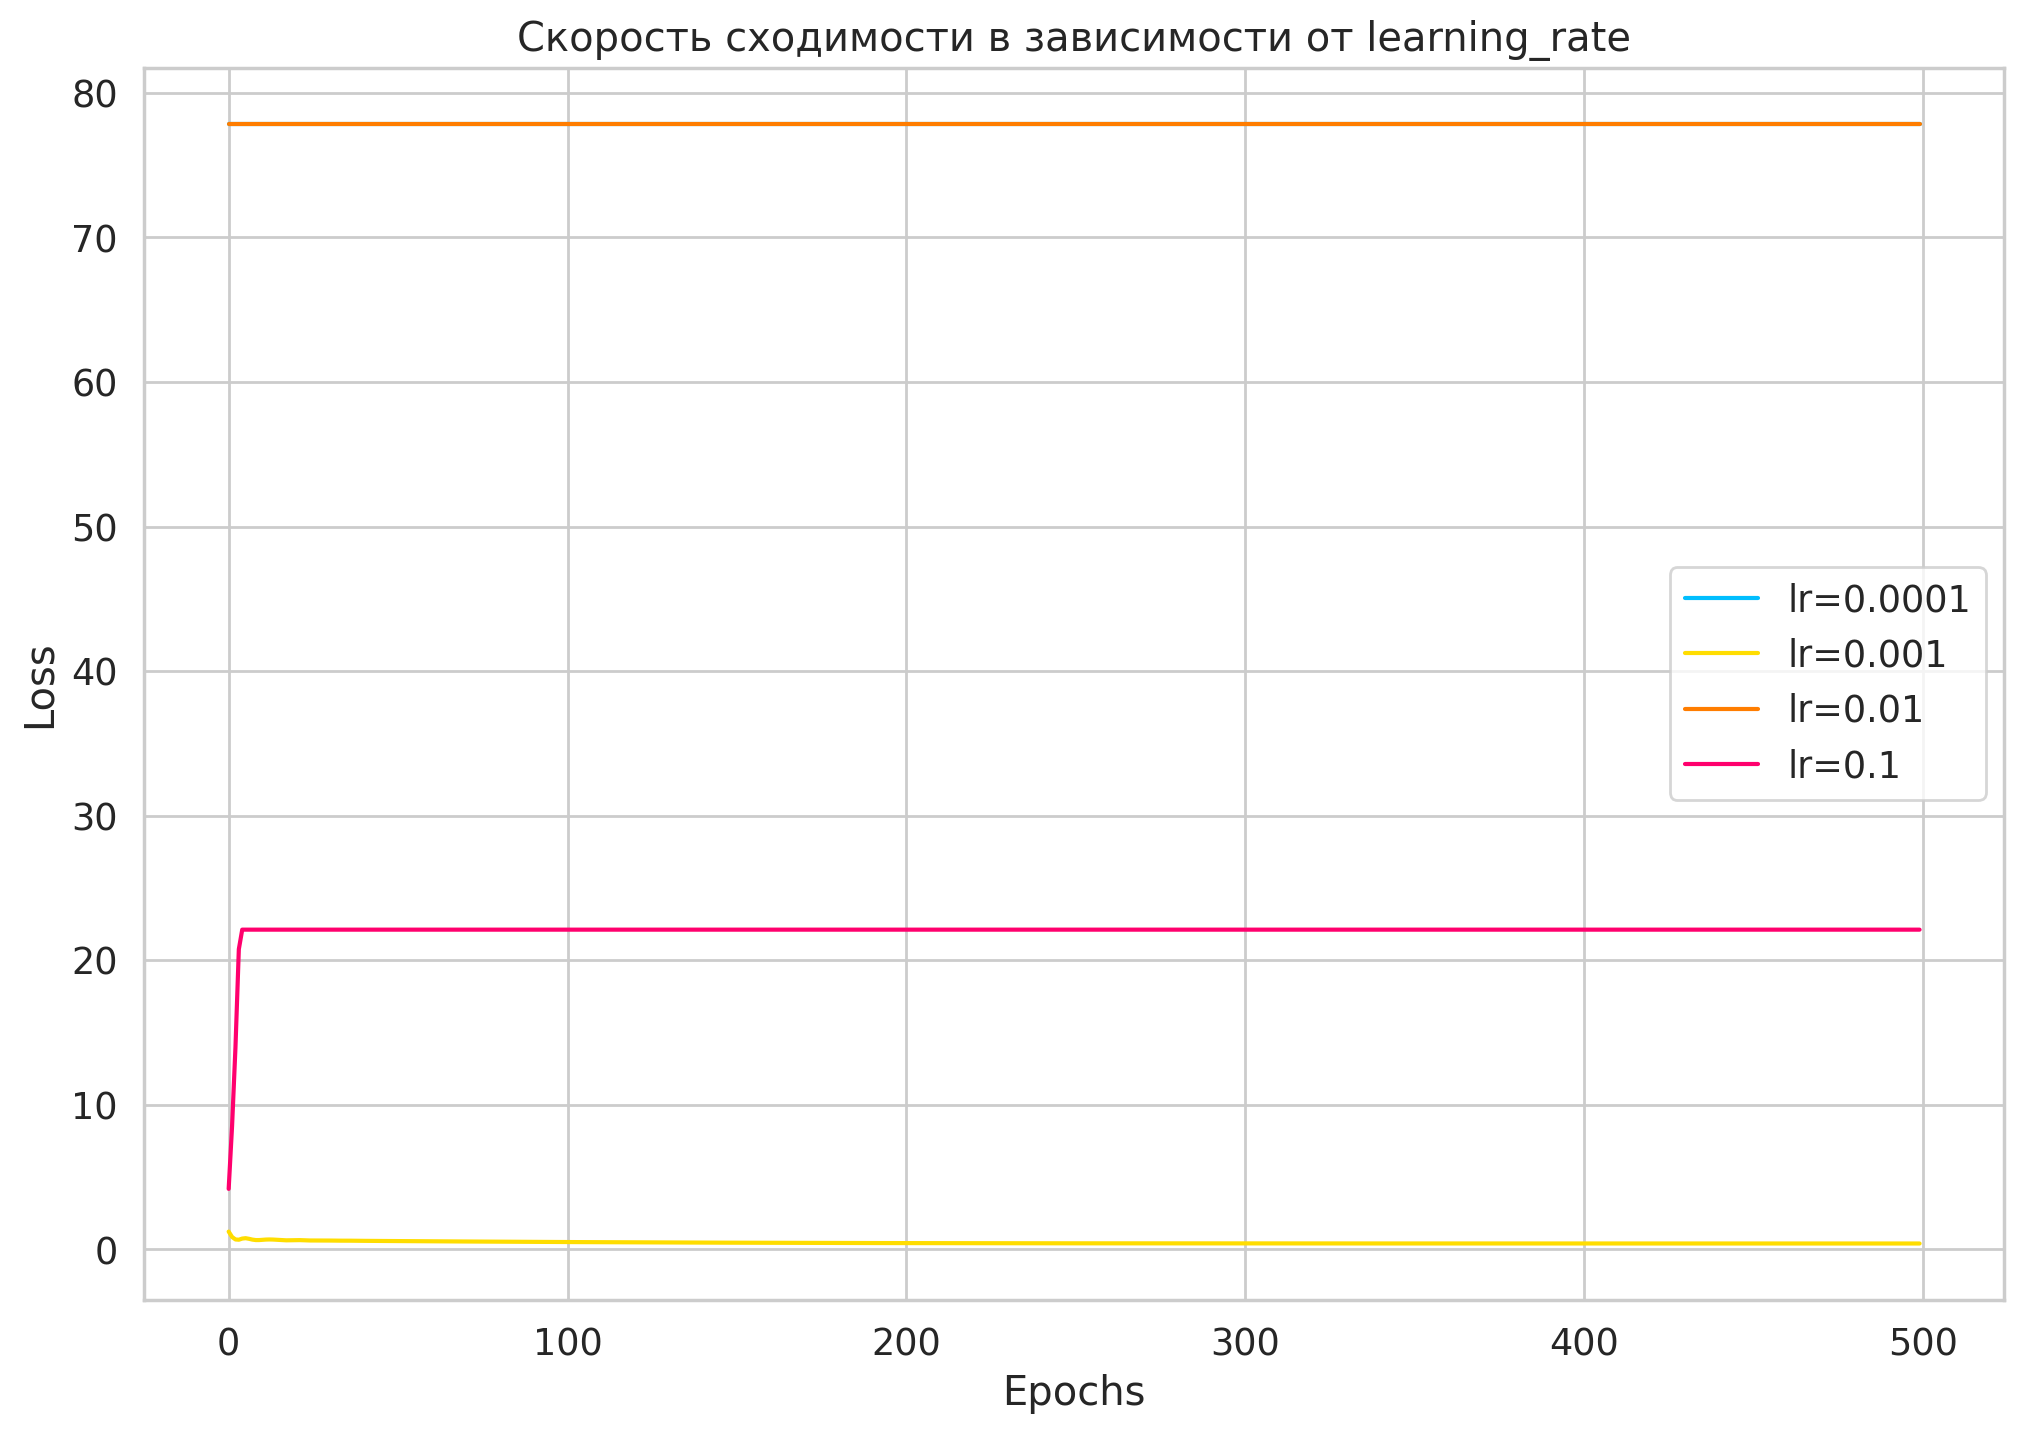

In [23]:

learning_rates = [0.0001, 0.001, 0.01, 0.1]
loss_per_lr = {}

for lr in learning_rates:
    net = Net(4).to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.BCELoss().to(device)

    losses = []
    for epoch in range(500):
        y_pred = net(X_train).squeeze()
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    loss_per_lr[lr] = losses

plt.figure(figsize=(12, 8))
for lr, losses in loss_per_lr.items():
    plt.plot(losses, label=f"lr={lr}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Скорость сходимости в зависимости от learning_rate")
plt.legend()
plt.show()

# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

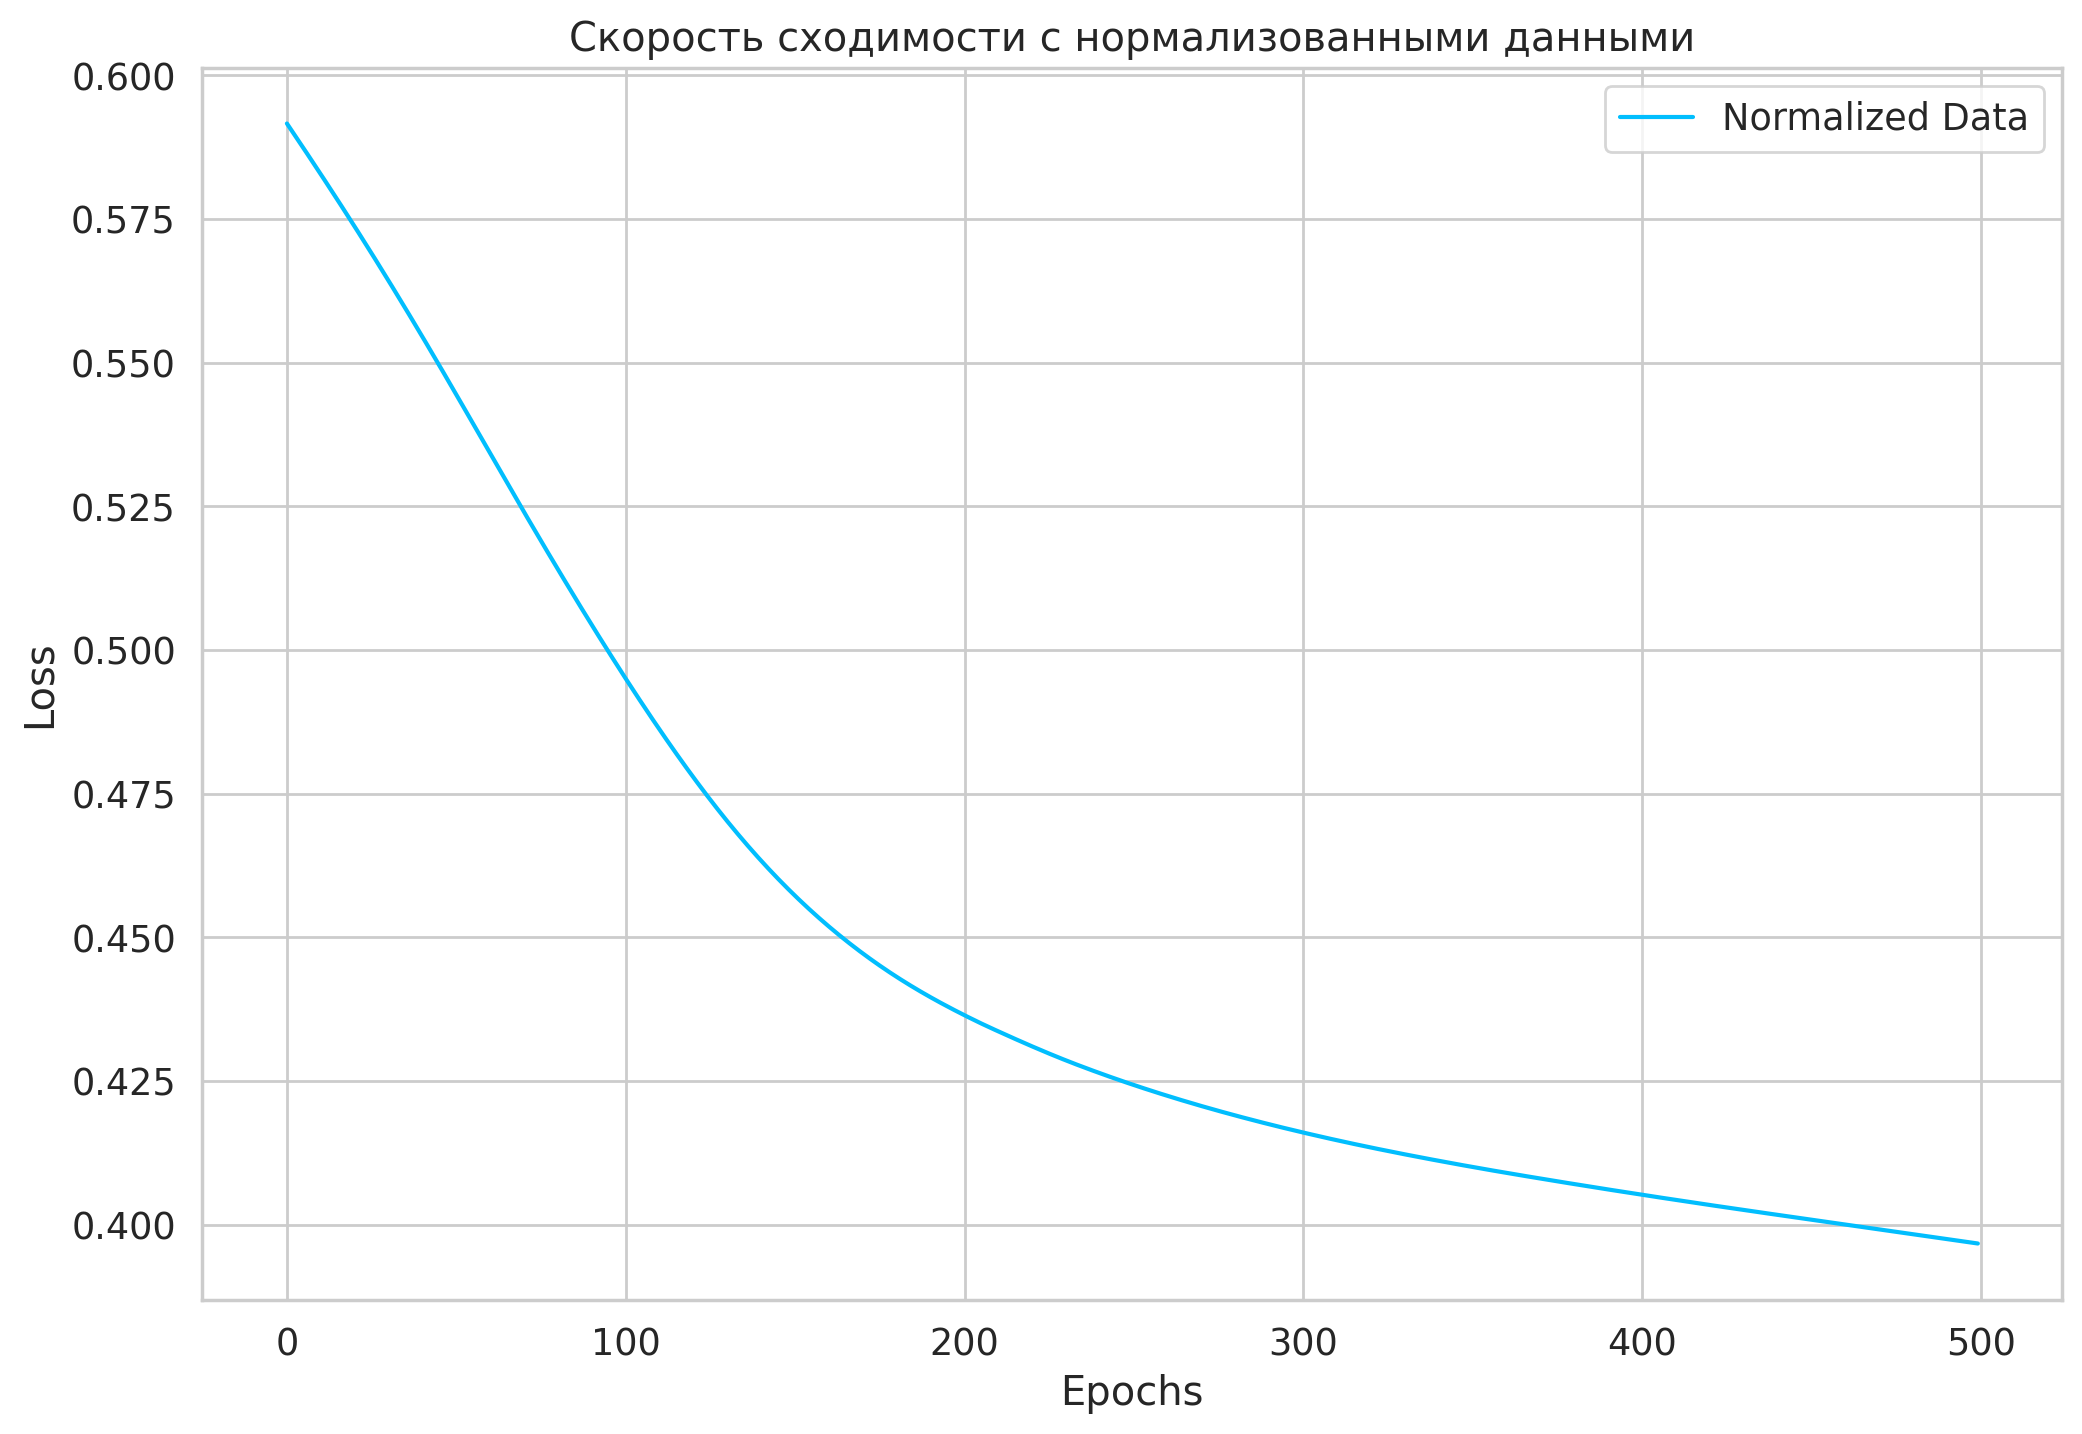

In [24]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_norm = torch.from_numpy(scaler.fit_transform(X_train.cpu())).float().to(device)
X_test_norm = torch.from_numpy(scaler.transform(X_test.cpu())).float().to(device)

net = Net(4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss().to(device)

losses = []
for epoch in range(500):
    y_pred = net(X_train_norm).squeeze()
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses, label="Normalized Data")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Скорость сходимости с нормализованными данными")
plt.legend()
plt.show()

# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


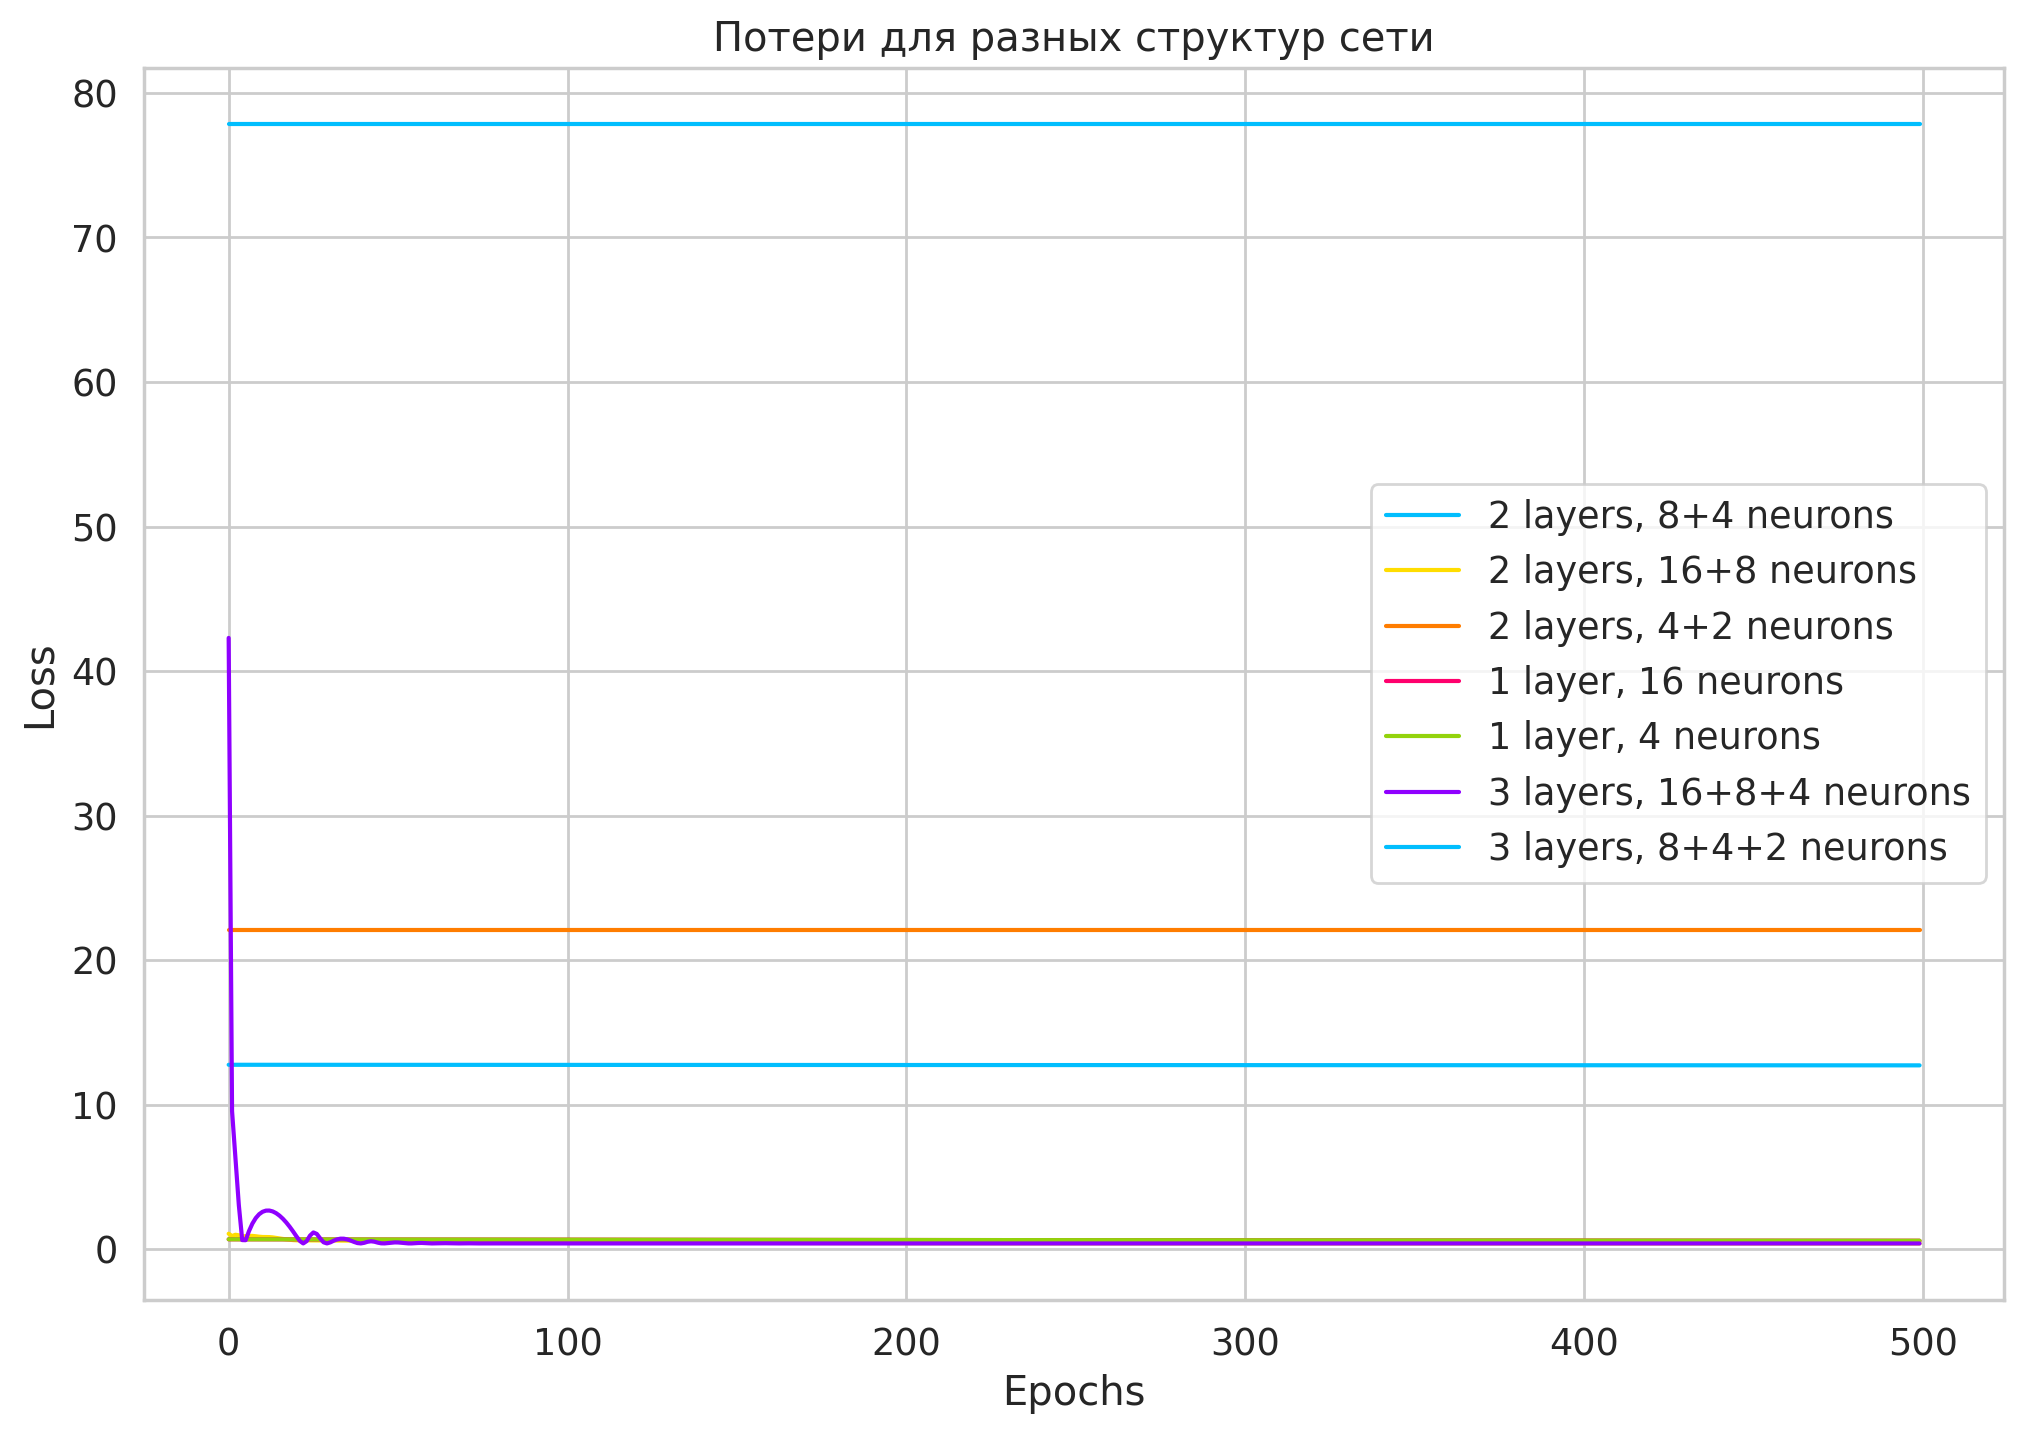

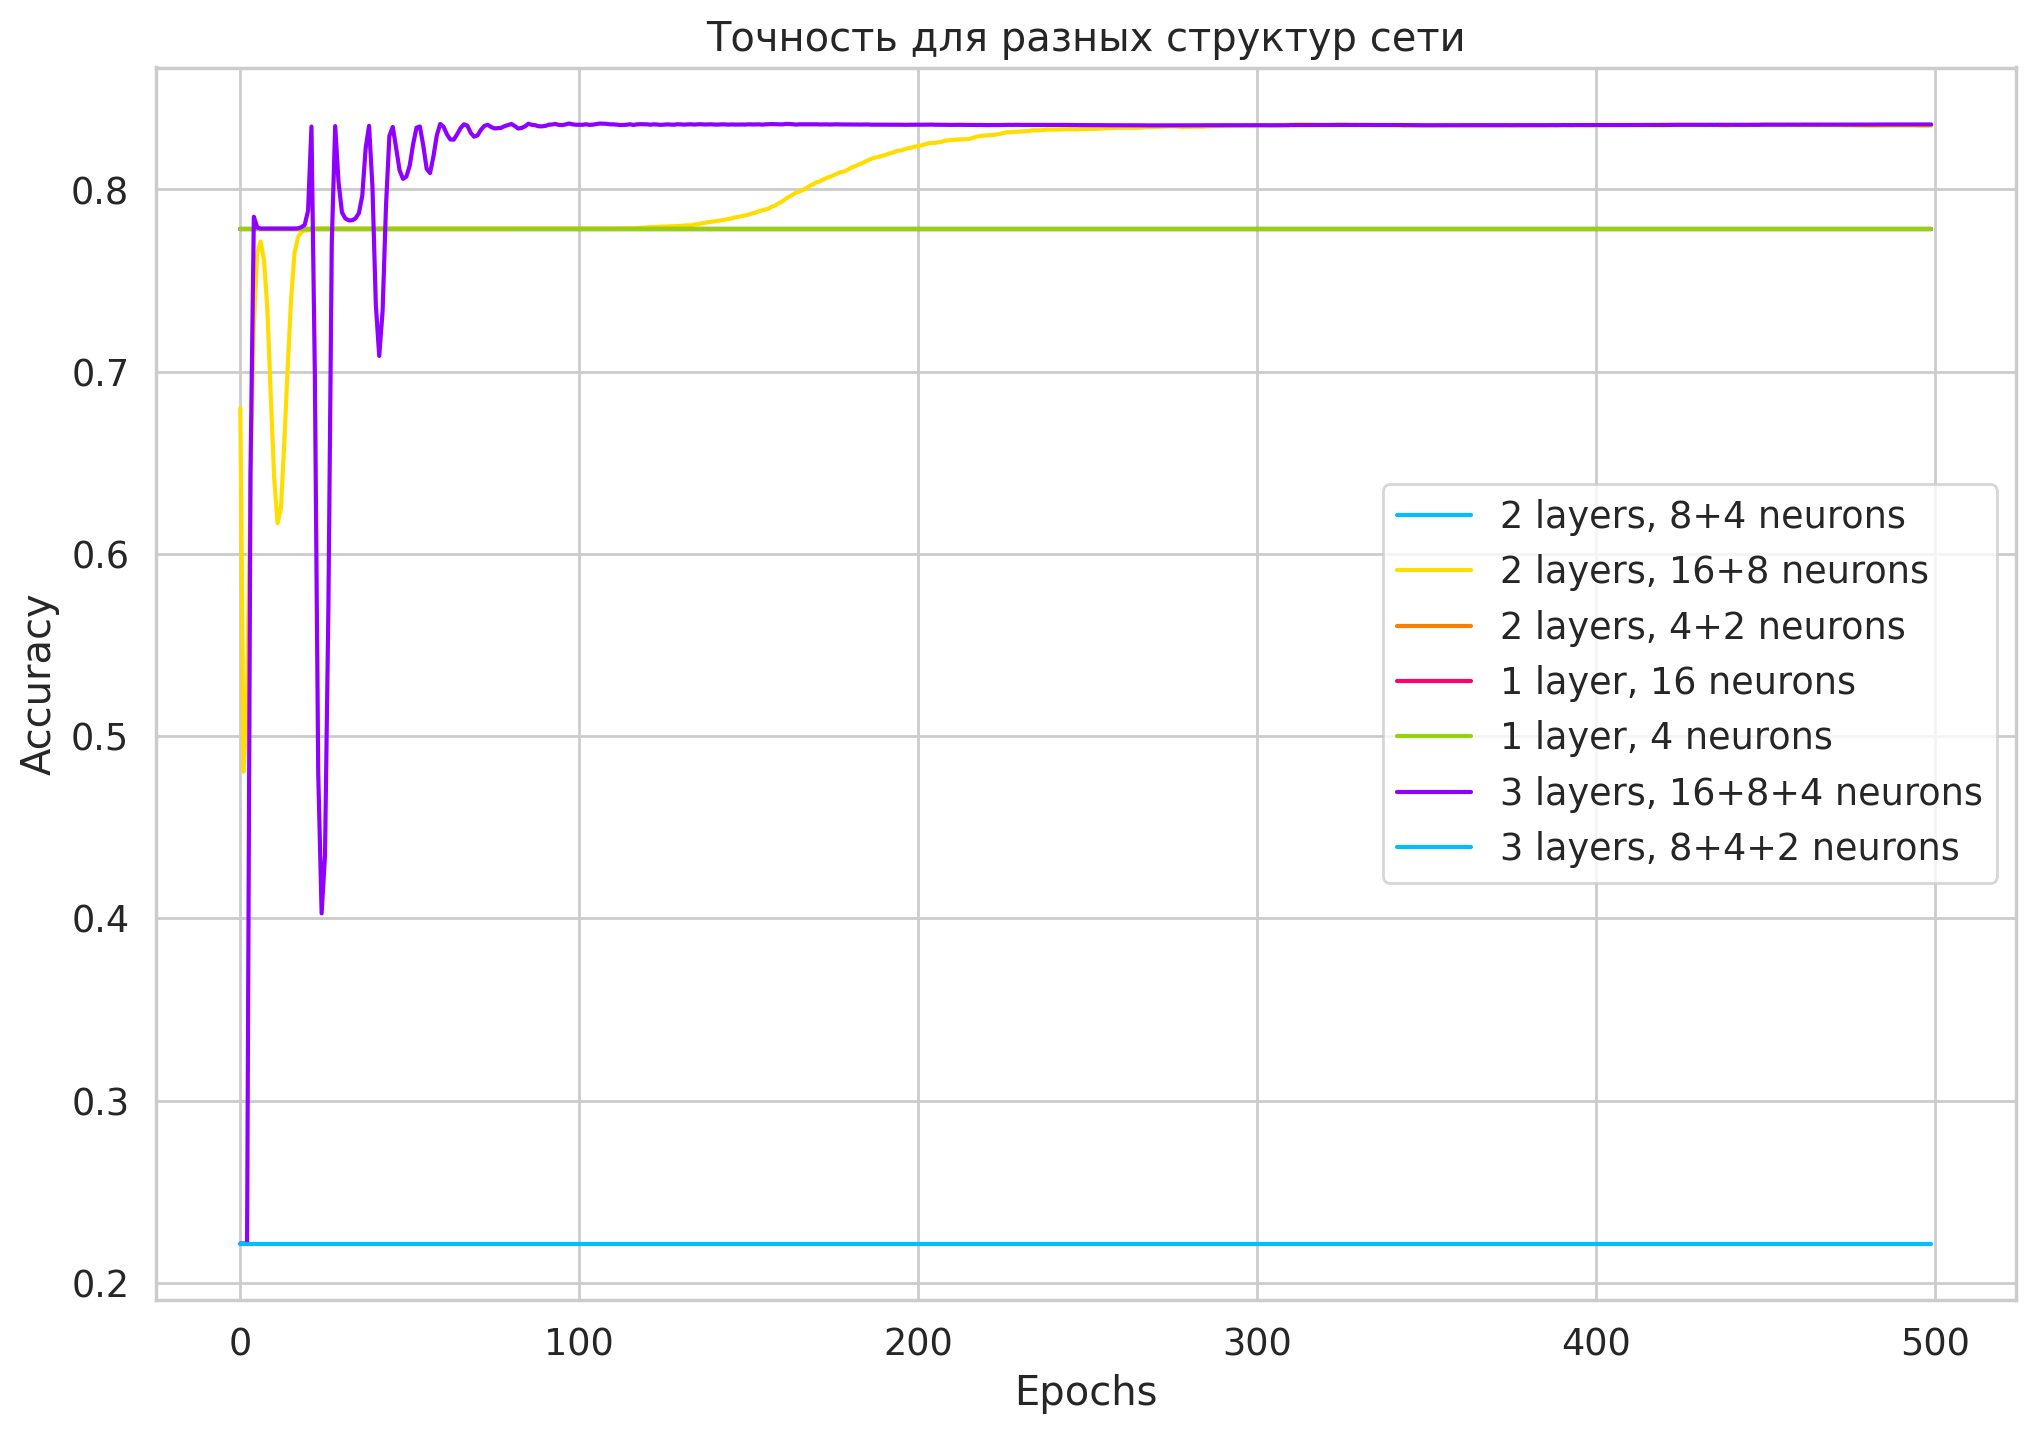

In [25]:
class NetModified(nn.Module):
    def __init__(self, n_features, hidden_layer_1, hidden_layer_2):
        super(NetModified, self).__init__()
        self.fc1 = nn.Linear(n_features, hidden_layer_1)
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.fc3 = nn.Linear(hidden_layer_2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

configurations = [
    {'layers': '2 layers, 8+4 neurons', 'hidden_layer_1': 8, 'hidden_layer_2': 4},
    {'layers': '2 layers, 16+8 neurons', 'hidden_layer_1': 16, 'hidden_layer_2': 8},
    {'layers': '2 layers, 4+2 neurons', 'hidden_layer_1': 4, 'hidden_layer_2': 2},
    {'layers': '1 layer, 16 neurons', 'hidden_layer_1': 16, 'hidden_layer_2': 0},
    {'layers': '1 layer, 4 neurons', 'hidden_layer_1': 4, 'hidden_layer_2': 0},
    {'layers': '3 layers, 16+8+4 neurons', 'hidden_layer_1': 16, 'hidden_layer_2': 8},
    {'layers': '3 layers, 8+4+2 neurons', 'hidden_layer_1': 8, 'hidden_layer_2': 4}
]

losses_per_config = {}
accuracies_per_config = {}

for config in configurations:
    net = NetModified(4, config['hidden_layer_1'], config['hidden_layer_2']).to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.BCELoss().to(device)

    losses = []
    accuracies = []

    for epoch in range(500):
        # Прогон по тренировочным данным
        y_pred = net(X_train).squeeze()
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Оценка точности на тестовой выборке
        y_test_pred = net(X_test).squeeze()
        test_acc = calculate_accuracy(y_test, y_test_pred.ge(.5).view(-1))
        accuracies.append(test_acc.item())

    losses_per_config[config['layers']] = losses
    accuracies_per_config[config['layers']] = accuracies

plt.figure(figsize=(12, 8))
for config, losses in losses_per_config.items():
    plt.plot(losses, label=f"{config}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Потери для разных структур сети")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for config, accuracies in accuracies_per_config.items():
    plt.plot(accuracies, label=f"{config}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Точность для разных структур сети")
plt.legend()
plt.show()


# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

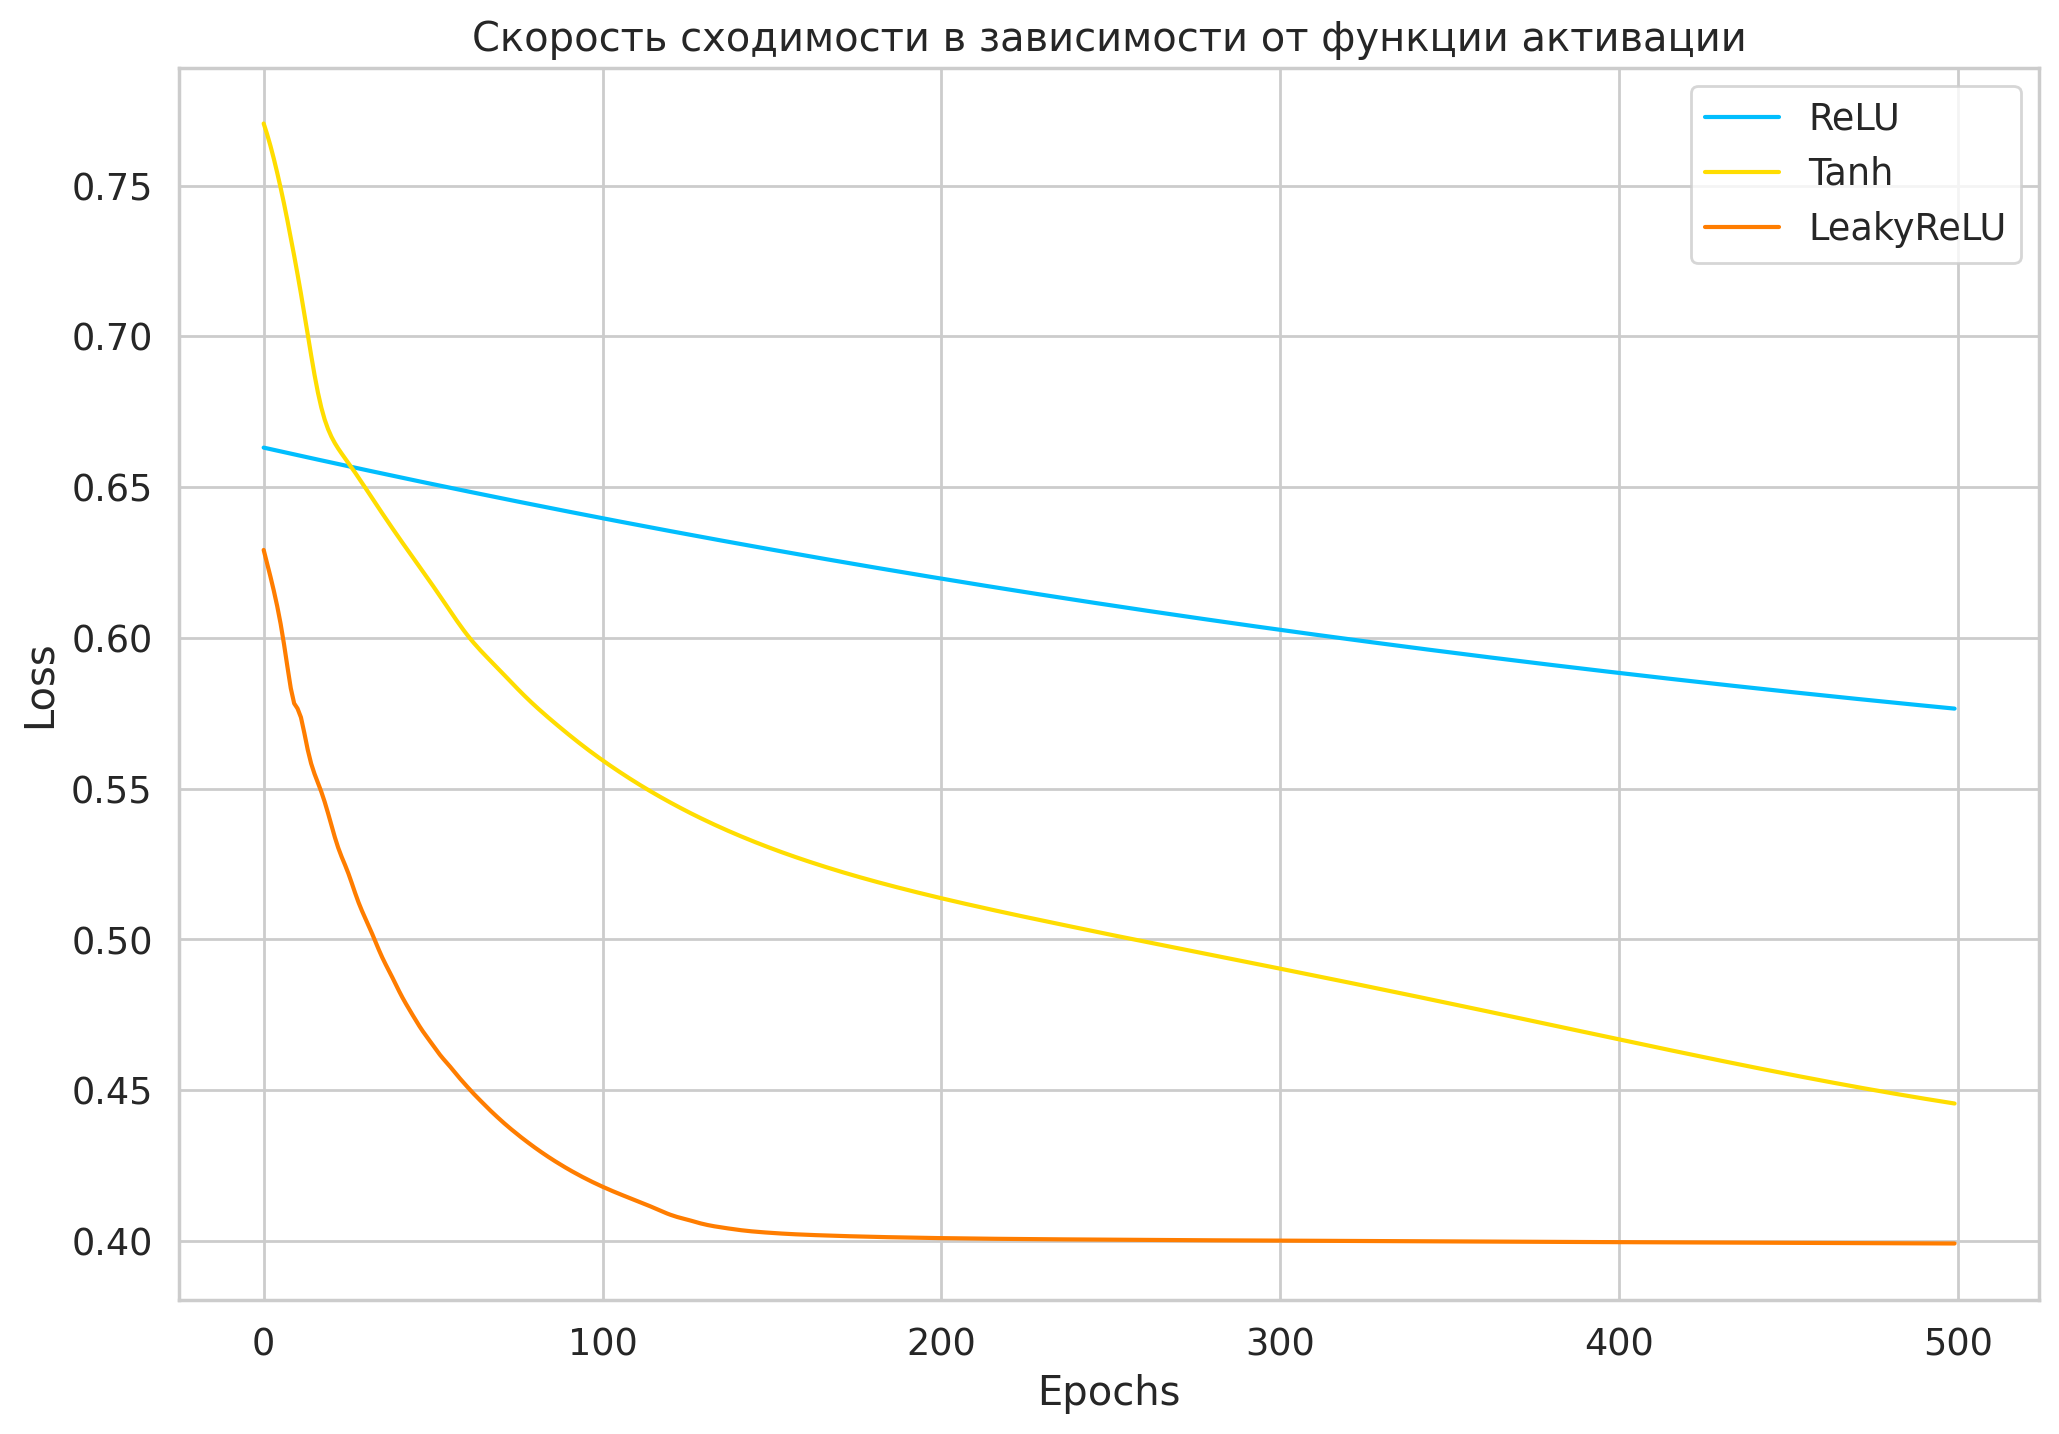

In [26]:


activations = {
    "ReLU": F.relu,
    "Tanh": torch.tanh,
    "LeakyReLU": F.leaky_relu
}

loss_per_activation = {}

for name, activation in activations.items():
    class NetActivation(nn.Module):
        def __init__(self, n_features):
            super(NetActivation, self).__init__()
            self.fc1 = nn.Linear(n_features, 8)
            self.fc2 = nn.Linear(8, 4)
            self.fc3 = nn.Linear(4, 1)
            self.activation = activation

        def forward(self, x):
            x = self.activation(self.fc1(x))
            x = self.activation(self.fc2(x))
            return torch.sigmoid(self.fc3(x))

    net = NetActivation(4).to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.BCELoss().to(device)

    losses = []
    for epoch in range(500):
        y_pred = net(X_train).squeeze()
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    loss_per_activation[name] = losses

# Построение графиков
plt.figure(figsize=(12, 8))
for name, losses in loss_per_activation.items():
    plt.plot(losses, label=name)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Скорость сходимости в зависимости от функции активации")
plt.legend()
plt.show()


# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

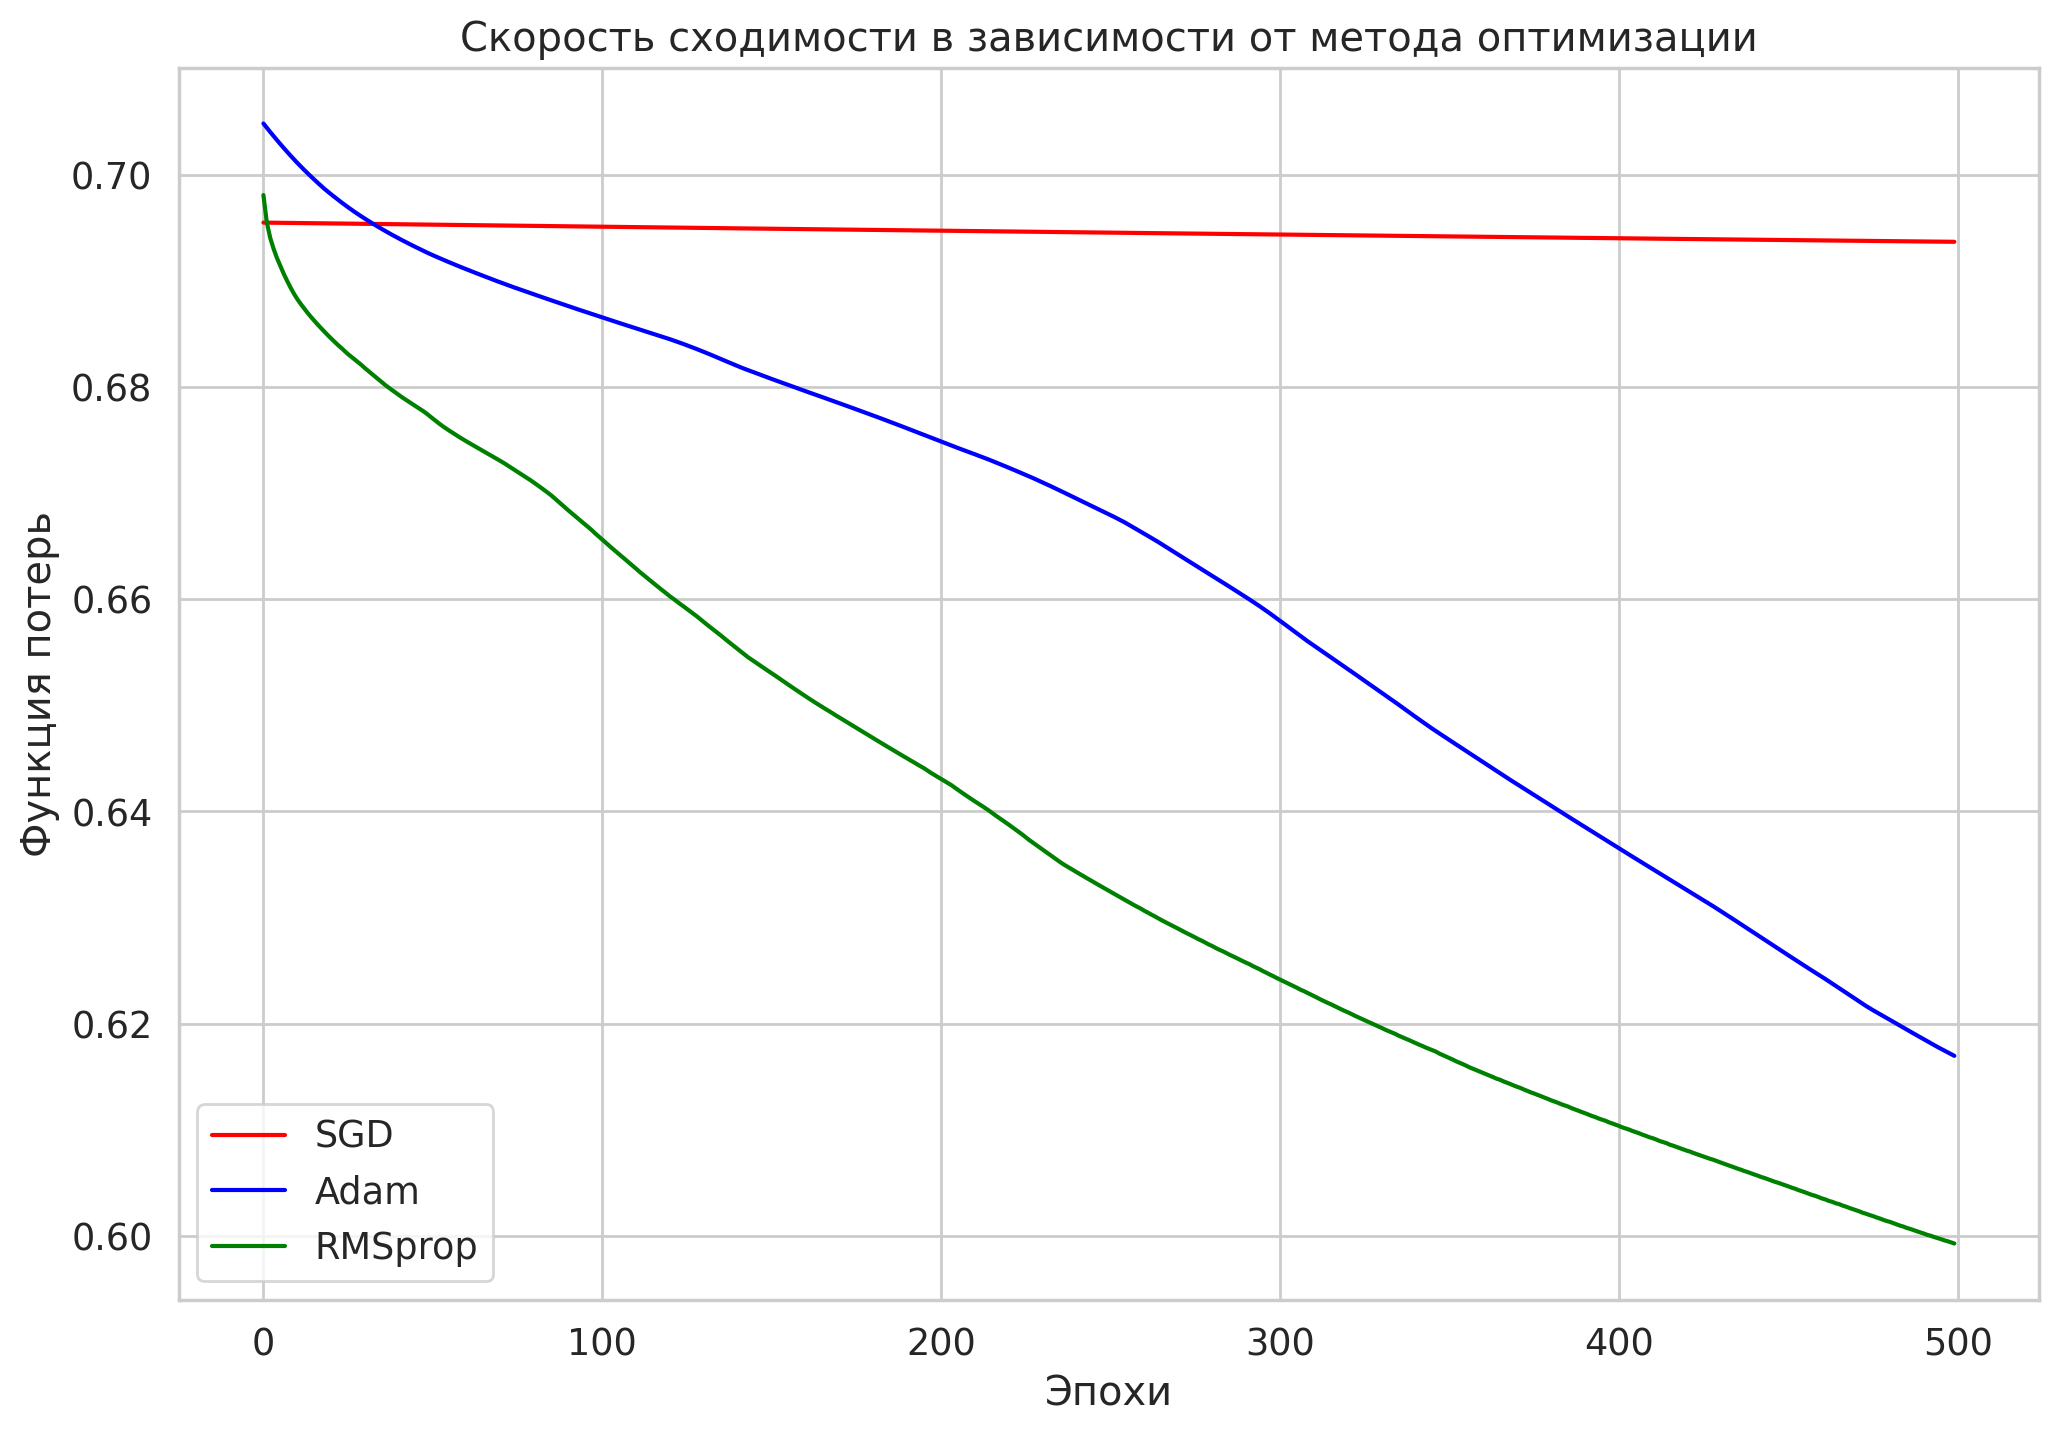

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Предполагаем, что X_train и y_train уже определены и находятся на нужном устройстве (device)
# Пример создания данных:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.randn(100, 4).to(device)
y_train = torch.randint(0, 2, (100,)).float().to(device)


# Определение простой нейронной сети
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Словарь с оптимизаторами и их функциями создания
optimizers = {
    "SGD": lambda params: optim.SGD(params, lr=0.001), # Градиентный спуск
    "Adam": lambda params: optim.Adam(params, lr=0.001), # Алгоритм Adam
    "RMSprop": lambda params: optim.RMSprop(params, lr=0.001) # Алгоритм RMSprop
}

loss_per_optimizer = {} # Словарь для хранения значений потерь по каждому оптимизатору

# Задаем набор цветов для графиков (сделаем их более различимыми)
colors = ["red", "blue", "green"]

for (name, opt_fn), color in zip(optimizers.items(), colors):
    # name - имя оптимизатора (например "SGD")
    # opt_fn - функция, которая создает экземпляр оптимизатора
    # color - цвет линии на графике
    net = Net(4).to(device) # Создание нейронной сети, перемещение на device
    optimizer = opt_fn(net.parameters()) # Создание экземпляра оптимизатора
    criterion = nn.BCELoss().to(device) # Создание функции потерь (бинарная кросс-энтропия) и перемещение на device

    losses = [] # Список для хранения потерь в процессе обучения для каждого оптимизатора
    for epoch in range(500): # 500 эпох обучения
        y_pred = net(X_train).squeeze() # Прямой проход через нейросеть и удаление размерности 1
        loss = criterion(y_pred, y_train) # Вычисление ошибки
        optimizer.zero_grad() # Обнуление градиентов
        loss.backward() # Обратное распространение ошибки
        optimizer.step() # Обновление параметров сети
        losses.append(loss.item()) # Добавление значения ошибки в список
    loss_per_optimizer[name] = losses # Запись потерь для текущего оптимизатора в словарь

plt.figure(figsize=(12, 8)) # Увеличение размера графика
for (name, losses), color in zip(loss_per_optimizer.items(), colors):
    # name - имя оптимизатора (например "SGD")
    # losses - список значений потерь для этого оптимизатора
    # color - цвет линии на графике
    plt.plot(losses, label=name, color=color) # Построение графика потерь для текущего оптимизатора с заданным цветом

plt.xlabel("Эпохи") # Подпись оси X
plt.ylabel("Функция потерь") # Подпись оси Y
plt.title("Скорость сходимости в зависимости от метода оптимизации") # Заголовок графика
plt.legend() # Отображение легенды
plt.show() # Отображение графика

# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

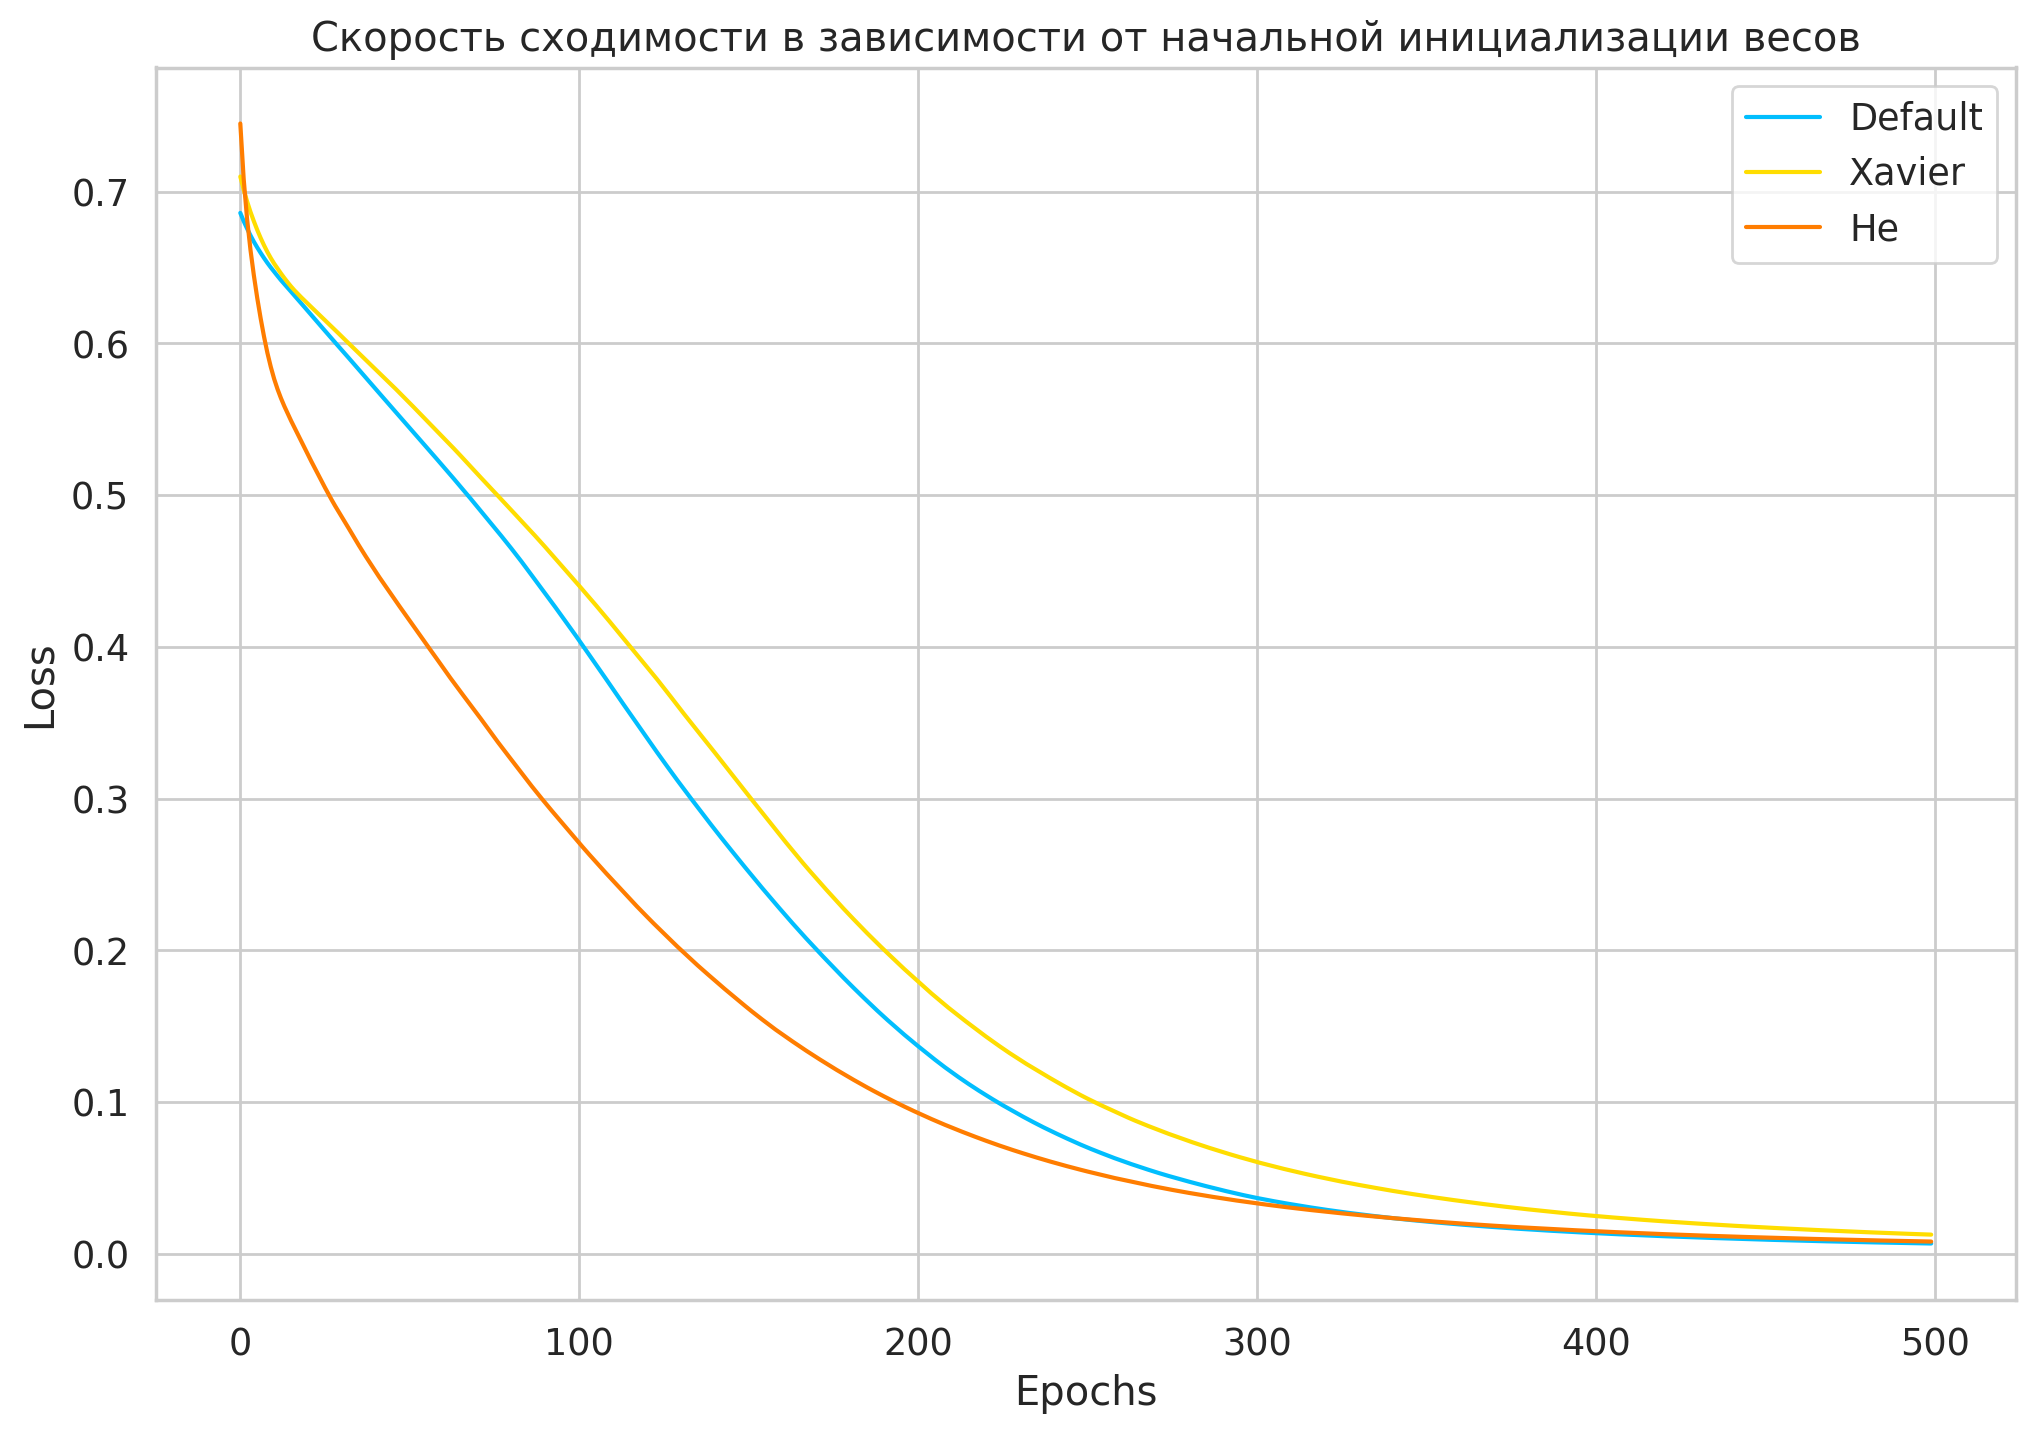

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Зададим seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)


# Определение простой нейронной сети
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


# Инициализации весов
initializations = {
    "Default": lambda layer: None,
    "Xavier": lambda layer: torch.nn.init.xavier_uniform_(layer.weight),
    "He": lambda layer: torch.nn.init.kaiming_uniform_(layer.weight, nonlinearity="relu")
}

# Генерация синтетических данных
X_train = torch.randn(100, 4)
y_train = torch.randint(0, 2, (100,)).float()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # используем gpu если доступен
X_train = X_train.to(device)
y_train = y_train.to(device)


loss_per_init = {}

for name, init_fn in initializations.items():
    net = Net(4).to(device)
    for layer in [net.fc1, net.fc2, net.fc3]:
        init_fn(layer)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.BCELoss().to(device)

    losses = []
    for epoch in range(500):
        y_pred = net(X_train).squeeze()
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    loss_per_init[name] = losses

# Построение графиков
plt.figure(figsize=(12, 8))
for name, losses in loss_per_init.items():
    plt.plot(losses, label=name)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Скорость сходимости в зависимости от начальной инициализации весов")
plt.legend()
plt.show()